# Introduction

Hello folks. So here is my analysis and modelling of Microsoft stock data. I am completely new to concepts of stocks and assets and most of what I know has been through this project. Therefore, I won't try to explain to the readers about what the stock market is. What I will explain, however, are the topics that I have analyzed in this project to the best of my understanding and interpret the results accordingly.

The project has been divided into the following 2 parts:


1.   Exploratory data analysis
2.   Data modelling

Let's jump into it.

# Exploratory Data Analysis

In [1]:
# import libraries por favor

from google.colab import files

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [2]:
uploaded = files.upload()

Saving MS_Stockprices.csv to MS_Stockprices.csv


In [3]:
# Daily stock prices from 1986 to 2024
# Source: "https://www.macrotrends.net/stocks/charts/MSFT/microsoft/stock-price-history"

df = pd.read_csv(r"/content/MS_Stockprices.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,13-03-1986,0.0552,0.0633,0.0552,0.0606,1031788800
1,14-03-1986,0.0606,0.0639,0.0606,0.0628,308160000
2,17-03-1986,0.0628,0.0644,0.0628,0.0639,133171200
3,18-03-1986,0.0639,0.0644,0.0617,0.0622,67766400
4,19-03-1986,0.0622,0.0628,0.0606,0.0611,47894400


Okay so here is a typical schema of stock price records. There is the **date** column, followed by the stock price at market **open**, the **high**est price it rose to during the day, the **low**est price it fell to and finally, the stock price at market **close** for the day. Commonly, it is called **OHLC** (yes, in the same order). The last column is **volume** which tells the total transactions of the stocks during the day.

In [4]:
# checking for null values
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [5]:
# checking feature data types
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

# Preprocessing

We want our date column to be of the type **datetime** and set as the index, as it helps with slicing & indexing with logical operations. Also, it may be advantageous to split the dates into day, month & year in case we require to do some monthly/yearly group operations.

In [6]:
# Convert data to datetime format
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")


# split date into day, month and year
df['Day'] = df['Date'].apply(lambda x: x.day)
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Year'] = df['Date'].apply(lambda x: x.year)


df = df[["Date", "Day", "Month", "Year", "Open", "High", "Low", "Close", "Volume"]]


# set date as index
df.set_index("Date", inplace=True)

df.head()

,Day,Month,Year,Open,High,Low,Close,Volume
Date,,,,,,,,
1986-03-13,13,3,1986,0.0552,0.0633,0.0552,0.0606,1031788800
1986-03-14,14,3,1986,0.0606,0.0639,0.0606,0.0628,308160000
1986-03-17,17,3,1986,0.0628,0.0644,0.0628,0.0639,133171200
1986-03-18,18,3,1986,0.0639,0.0644,0.0617,0.0622,67766400
1986-03-19,19,3,1986,0.0622,0.0628,0.0606,0.0611,47894400


1986 to 2024 is just too long a time period to plot static graphs so I'm clipping out the data before 2015 to emphasize on the visuals. But before that, I'm going to check the correlation between all the numerical columns

# Correlation of stock prices and their trends over time

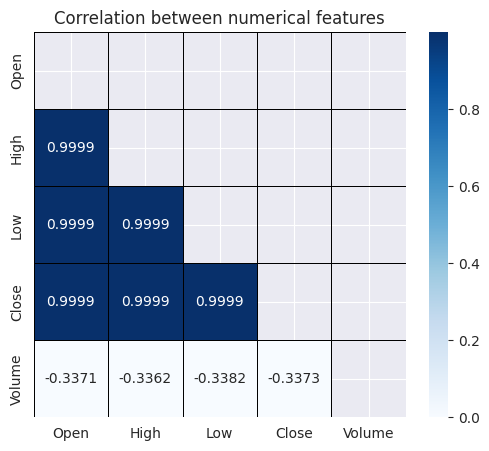

In [7]:
# Correlation between the numeric features price categories

plt.figure(figsize=(6,5))
all_features = ["Open", "High", "Low", "Close", "Volume"]

# correlation matrix
all_corr = df[all_features].corr()

# masking matrix to mask the upper triangle of correlation matrix
mask = np.triu(np.ones_like(all_corr))

# visualize in seaborn heatmap
sns.heatmap(all_corr, mask=mask, annot=True, fmt=".4f", vmin=0, cmap="Blues", linewidths=0.5, linecolor='black')
plt.title("Correlation between numerical features")
plt.show()

The series for OHLC are virtually the same, which is pretty much expected. I mean, the stock price normally doesn't fluctuate massively in a **single day** that will cause a major difference in their values. Conversely, there's a moderate negative correlation between the prices and the volume, meaning that the shares changed hands lesser as the stock prices increased because probably people are more keen to sell than buy stocks in that situation.

Along with the correlation, another thing I'm tempted to see before we slice the dataset is the distribution of the numerical columns.

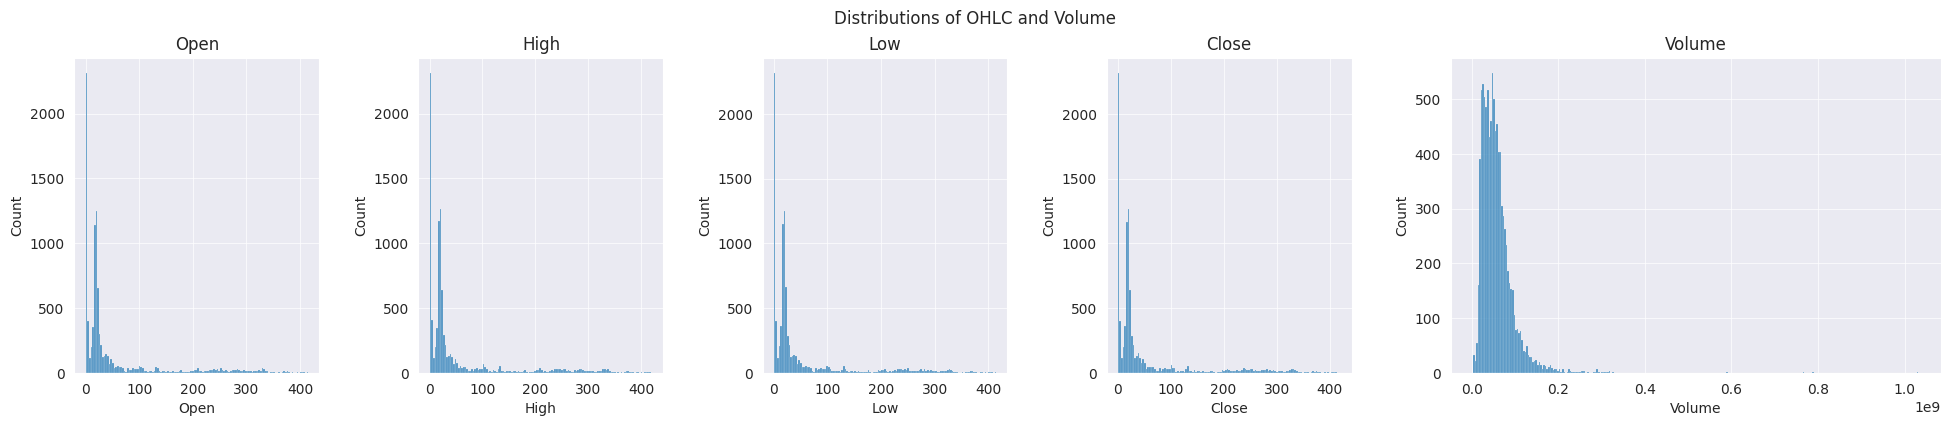

In [8]:
# View distributions of the prices and volumes

fig, ax = plt.subplots(1, 5, figsize=(20, 4.5), gridspec_kw={'width_ratios': [1,1,1,1,2]})

for i, feat in enumerate(["Open", "High", "Low", "Close", "Volume"]):
    sns.histplot(df[feat], ax=ax[i])
    ax[i].set_title(feat)
    ax[i].grid(True, alpha=0.7)

plt.tight_layout(pad=2.5)
plt.suptitle("Distributions of OHLC and Volume")
plt.show()

While the distribution of **Volume** may actually be correct, the rest are not representative of the population. That is because, the average price of stocks (as we will see later) keep increasing over the years. Therefore, barring a major recession, values below 100 (showing the highest probability) may never actually occur again. The distribution of OHLC is a function of time, which is better demonstrated by the boxplots below.

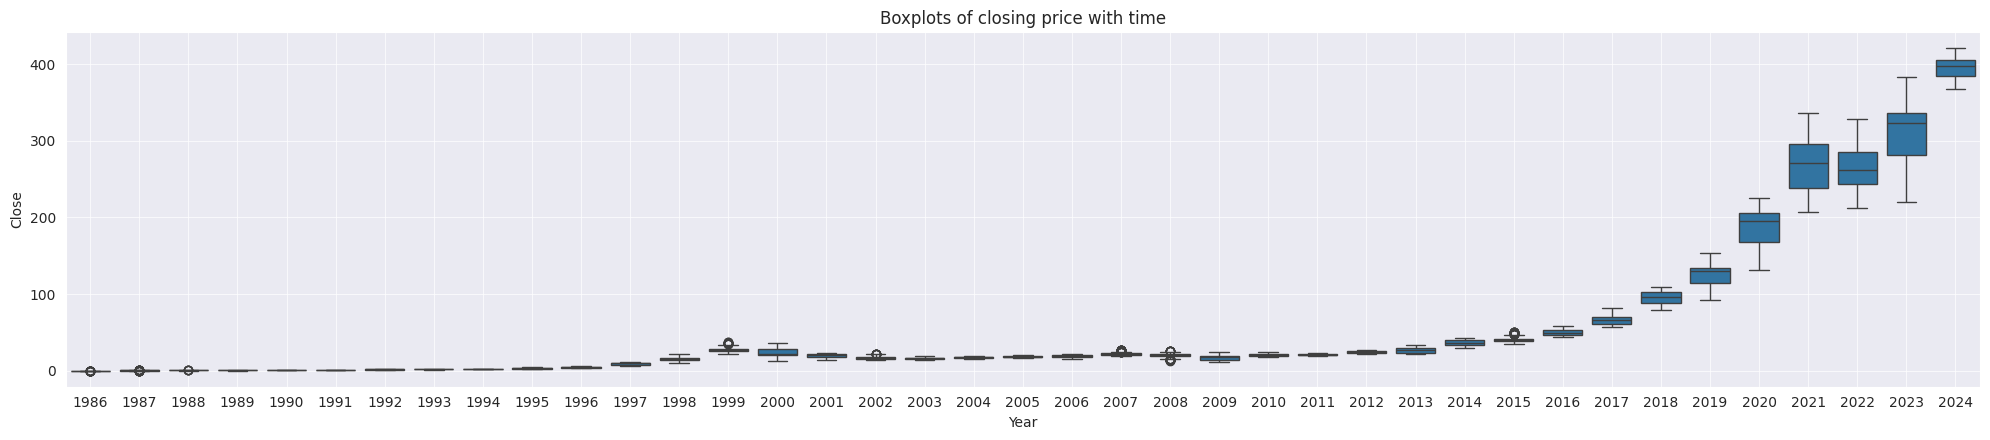

In [9]:
plt.figure(figsize=(20, 4.5))
sns.boxplot(data=df, x='Year', y='Close')
plt.title("Boxplots of closing price with time")
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

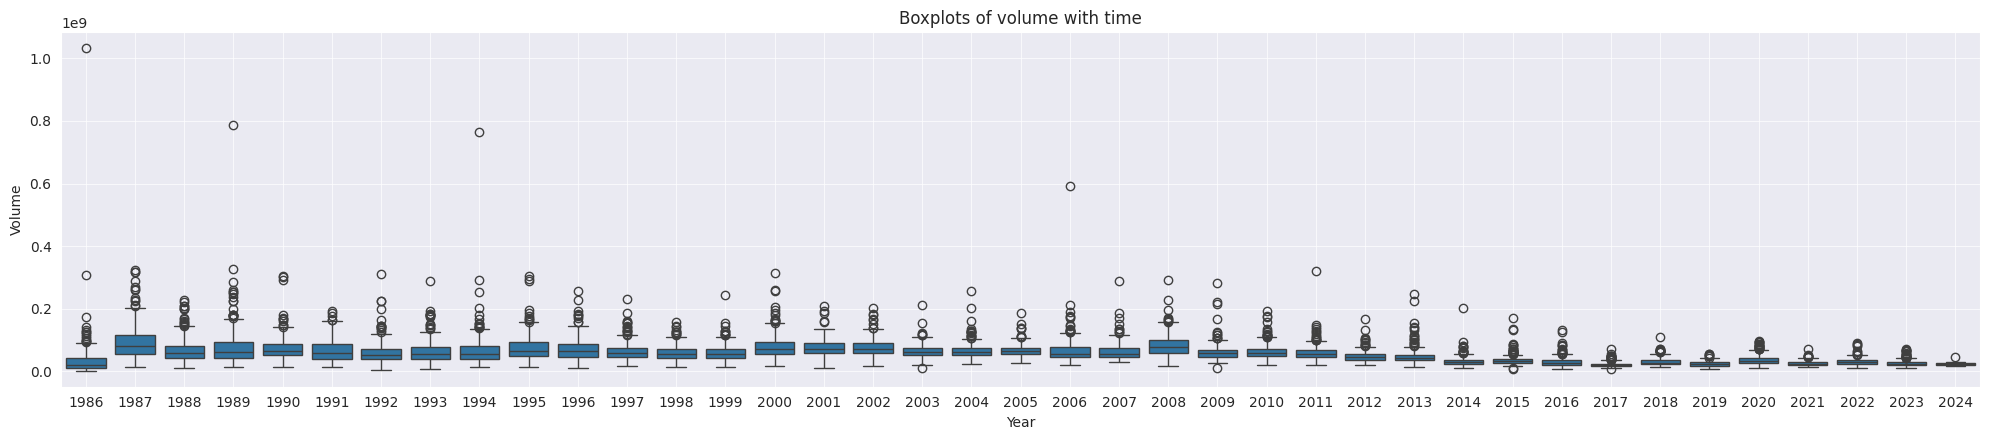

In [10]:
plt.figure(figsize=(20, 4.5))
sns.boxplot(data=df, x='Year', y='Volume')
plt.title("Boxplots of volume with time")
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

As stated before, the trend of the stock prices rise with time. Whereas the volume is slightly on the decline

In [11]:
# Slicing dataset from 2015

df = df.loc["2015":]

**Close** and **Volume** are the more important features. Let's have a look at their long term trends.

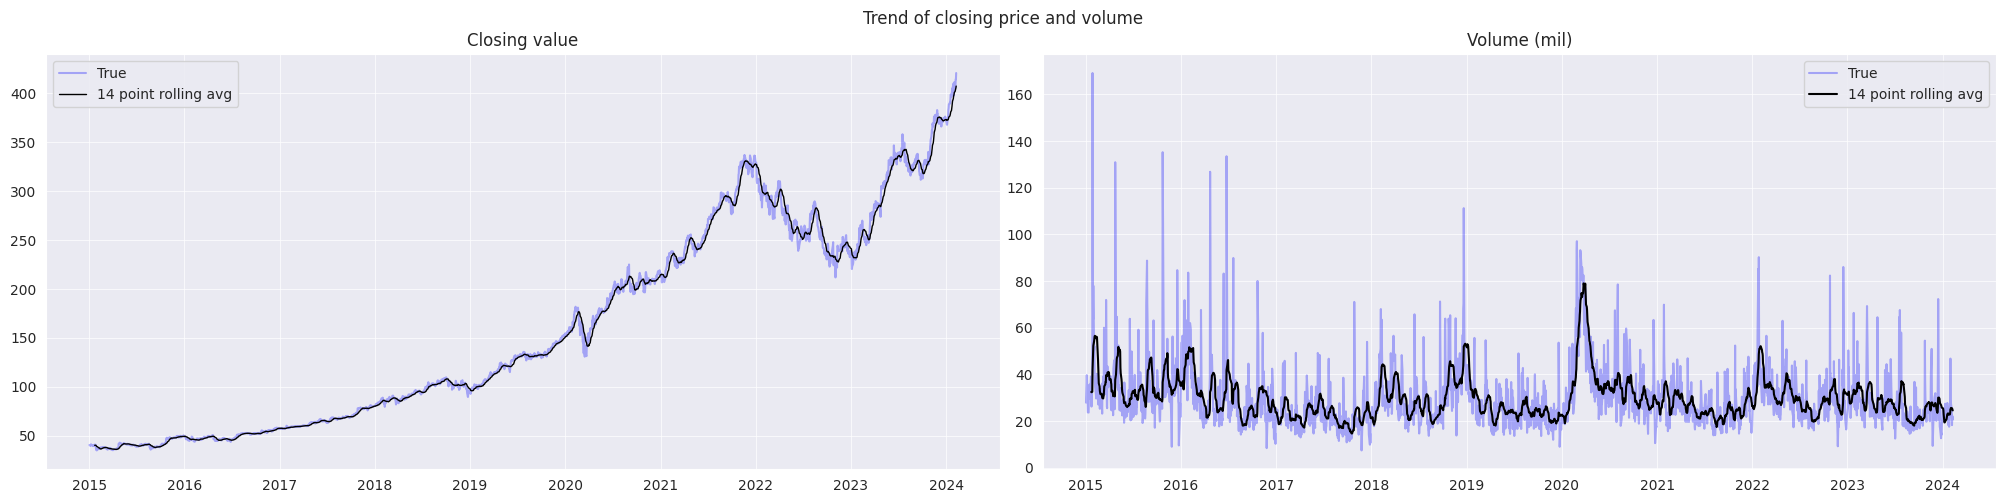

In [12]:
# View true values and rolling mean

plt.figure(figsize=(20, 5))

# true values
plt.subplot(1, 2, 1)
plt.plot(df["Close"], color='blue', alpha=0.3, label="True")
plt.plot(df["Close"].rolling(14).mean(), color='black', linewidth=1, label="14 point rolling avg")
plt.title("Closing value")
plt.legend()
plt.grid(True, alpha=0.7)

# rolling mean
plt.subplot(1, 2, 2)
plt.plot((df["Volume"]/1000000), color='blue', alpha=0.3, label="True")
plt.plot((df["Volume"]/1000000).rolling(14).mean(), color='black', label="14 point rolling avg")
plt.title("Volume (mil)")
plt.legend()
plt.grid(True, alpha=0.7)

plt.suptitle("Trend of closing price and volume")
plt.tight_layout(pad=0.5)
plt.show()

Certain news and announcements cause the value of a stock to rise or fall based on the implications of the announcements (such as acquisitions, competition from others, recession, etc). I have looked into 4 such announcements and news that had a sharp impact on the stock prices, namely, COVID-19, the recession warning in early 2022, partnership with OpenAI and other AI advancements in 2023.


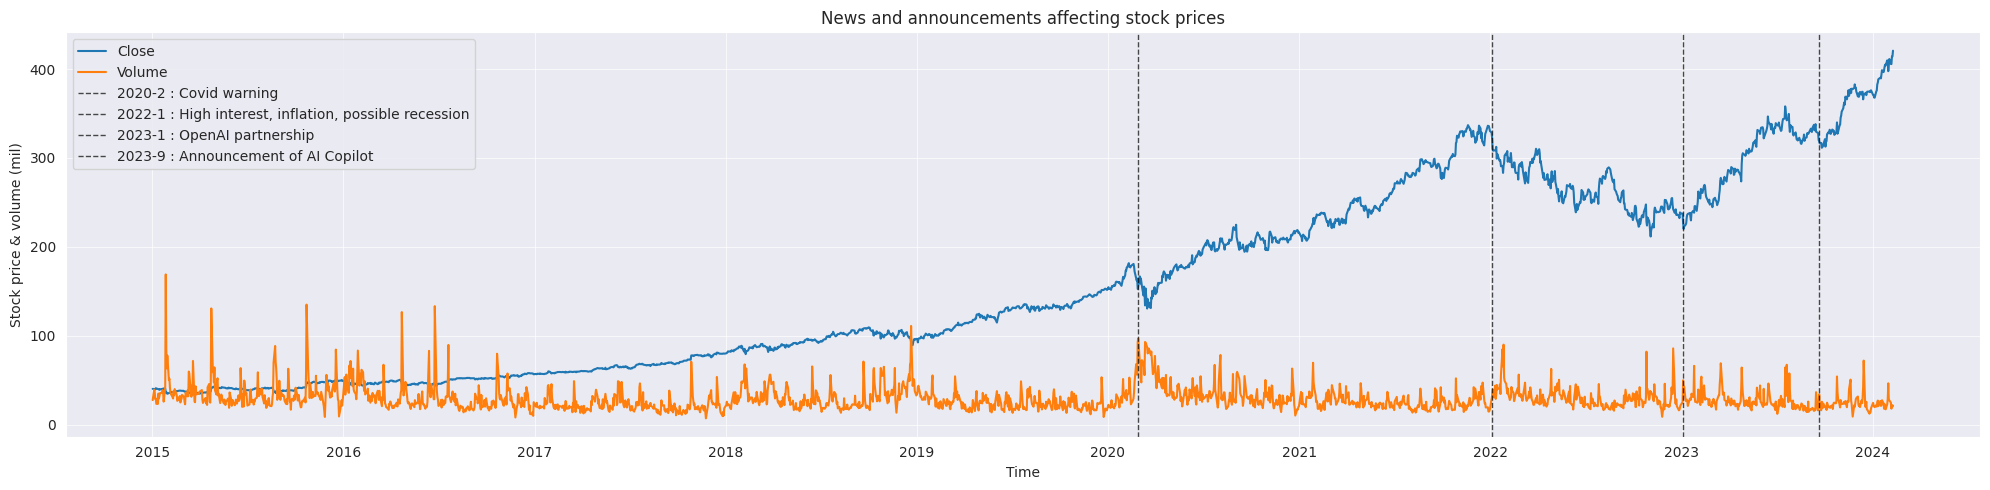

In [13]:
news = ["Covid warning", "High interest, inflation, possible recession", "OpenAI partnership", "Announcement of AI Copilot"]
datess = [pd.to_datetime(x) for x in ["2020-02-27", "2022-01-03", "2023-01-03", "2023-09-21"]]
plt.figure(figsize=(20, 5))

plt.plot(df['Close'], label="Close")
plt.plot(df['Volume']/1000000.0, label="Volume")
for ns, dts in zip(news, datess):
    plt.axvline(x=dts, label=f"{dts.year}-{dts.month} : {ns}", linestyle='dashed', linewidth=1, color='black', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Stock price & volume (mil)")
plt.title("News and announcements affecting stock prices")
plt.legend()
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

# Candlestick plot

There's a more informative way of visualizing trend of stock prices over time called a candlestick plot. It is a plot, not made of data points but **candlesticks**, which have a rectangular **body** with 2 **wicks** on the top and bottom. A single candlestick represents the OHLC information during a chosen period. In contrast with a rolling mean that simply returns the average over n days, a candlestick shows the highest high, the lowest low and the first open and last close during the period of n days.

Candlestick figure details:

*   The height of the **body** is given by the difference between the first open and last close prices during the period. If close > open then it is of one color (here green), if close < open, it's of another color (red)

*   The **wicks** denote the highest and lowest price during the period.

The candlestick plot here is contructed from weekly data, i.e., a 7 day period.

In [14]:
# aggregate data by weeks
weekly_data = df.resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
})

# converting the date type index back into a column for candlestick object
weekly_data.reset_index(inplace=True)


# Create candlestick object
candlestick = go.Candlestick(
    x=weekly_data['Date'],
    open=weekly_data['Open'],
    high=weekly_data['High'],
    low=weekly_data['Low'],
    close=weekly_data['Close']
)

# Create figure and add candlesticks
fig = go.Figure(data=[candlestick])

# Update figure layout
fig.update_layout(
    width=1800,
    height=800,
    title='Weekly Candlestick Chart. First Open, maximum High, minimum Low, last Close',
    xaxis_title='Date',
    yaxis_title='OHLC'
)

fig.show()

# Seasonal decompose

Time series data Y(t) can often be decomposed into three main components: a trend component T(t), a seasonal component S(t), and the residuals (or noise) R. This decomposition helps in understanding the underlying patterns and behaviors within the time series data. The decomposition can be performed either additively or multiplicatively, depending on the nature of the data and the relationships between the components.

Additive decomposition: Y(t) = T(t) + S(t) + R

Multiplicative decomposition: Y(t) = T(t) × S(t) × R

Visualizing the decomposition is much better than reading formulae, so see below.

In [15]:
# Aggregate monthly data
periodic_df = df.resample('M').mean()


# get decomposition objects for closing prices
close_mult_decom = seasonal_decompose(periodic_df.Close, model='multiplicative')
close_add_decom = seasonal_decompose(periodic_df.Close, model='additive')

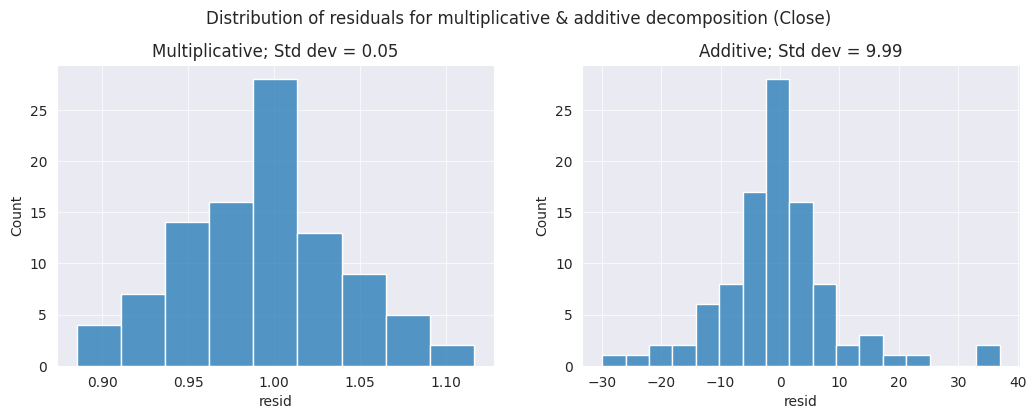

In [16]:
plt.figure(figsize=(11, 4.5))

# multiplicative decomposition residuals
plt.subplot(1, 2, 1)
sns.histplot(close_mult_decom.resid)
plt.title(f"Multiplicative; Std dev = {close_mult_decom.resid.std():.02f}")
plt.grid(True, alpha=0.7)

# additive decomposition residuals
plt.subplot(1, 2, 2)
sns.histplot(close_add_decom.resid)
plt.title(f"Additive; Std dev = {close_add_decom.resid.std():.02f}")
plt.grid(True, alpha=0.7)

plt.tight_layout(pad=3)
plt.suptitle("Distribution of residuals for multiplicative & additive decomposition (Close)")
plt.show()

To determine the appropriate decomposition type, it's essential to analyze the residuals. Upon examining the histogram, it's evident that both residuals exhibit a normal distribution. The difference in mean and standard deviations between the residuals arises from the nature of the decompositions. It is often desirable to have normally distributed residuals or residuals as a stationary series to denote a good decomposition. Residual with their own trends and seasonalities denote improper decomposition.


For this scenario, I've chosen multiplicative decompose as there is a gradual rise in the trend. Also, I imagine the price of the stocks to be a product of a constant pattern of transactions (e.g. in a new financial year or quarterly or any time after a company publishes their stock reports) and the purchasing power of people (the trend).

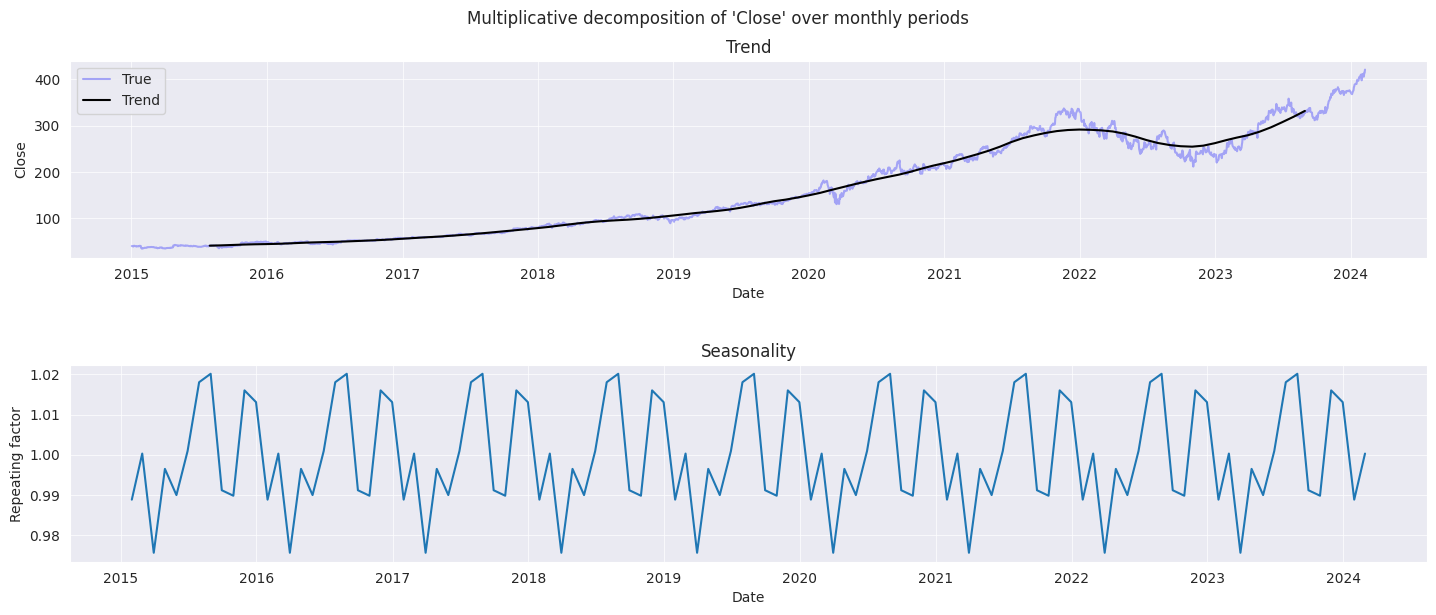

In [17]:
plt.figure(figsize=(15, 6.5))

plt.subplot(2, 1, 1)

# Plot trend component
plt.plot(df['Close'], color='blue', alpha=0.3, label="True")
plt.plot(close_mult_decom.trend, color='black', label='Trend')
plt.title("Trend")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.grid(True, alpha=0.7)

# plot seasonal component
plt.subplot(2, 1, 2)
plt.plot(close_mult_decom.seasonal)
plt.xlabel("Date")
plt.ylabel("Repeating factor")
plt.title("Seasonality")
plt.grid(True, alpha=0.7)

plt.tight_layout(pad=3)
plt.suptitle("Multiplicative decomposition of 'Close' over monthly periods")
plt.show()

In [18]:
# get decomposition objects for volume
vol_mult_decom = seasonal_decompose(periodic_df.Volume, model='multiplicative')
vol_add_decom = seasonal_decompose(periodic_df.Volume, model='additive')

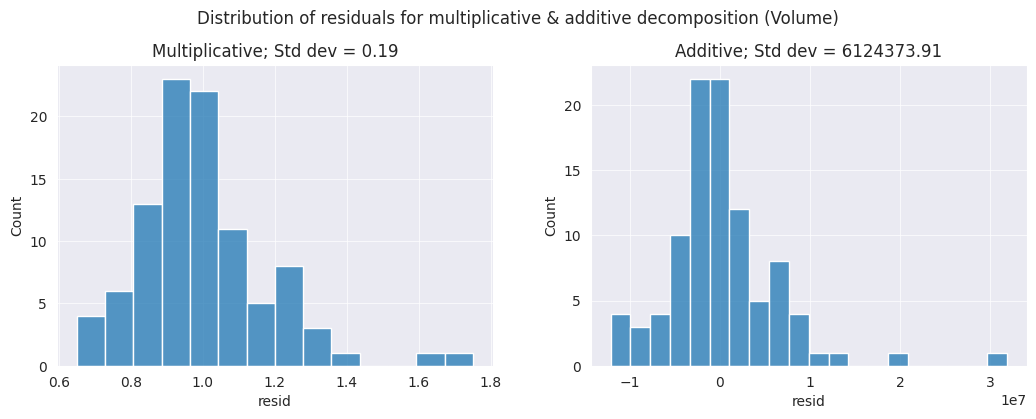

In [19]:
plt.figure(figsize=(11, 4.5))

# multiplicative decomposition residuals
plt.subplot(1, 2, 1)
sns.histplot(vol_mult_decom.resid)
plt.title(f"Multiplicative; Std dev = {vol_mult_decom.resid.std():.02f}")
plt.grid(True, alpha=0.7)


# additive decomposition residuals
plt.subplot(1, 2, 2)
sns.histplot(vol_add_decom.resid)
plt.title(f"Additive; Std dev = {vol_add_decom.resid.std():.02f}")
plt.grid(True, alpha=0.7)

plt.tight_layout(pad=3)
plt.suptitle("Distribution of residuals for multiplicative & additive decomposition (Volume)")
plt.show()

I've opted for multiplicative decomposition for the volume data. The intention was to compare the seasonalities of both the close and volume series, to see if any patterns are present.

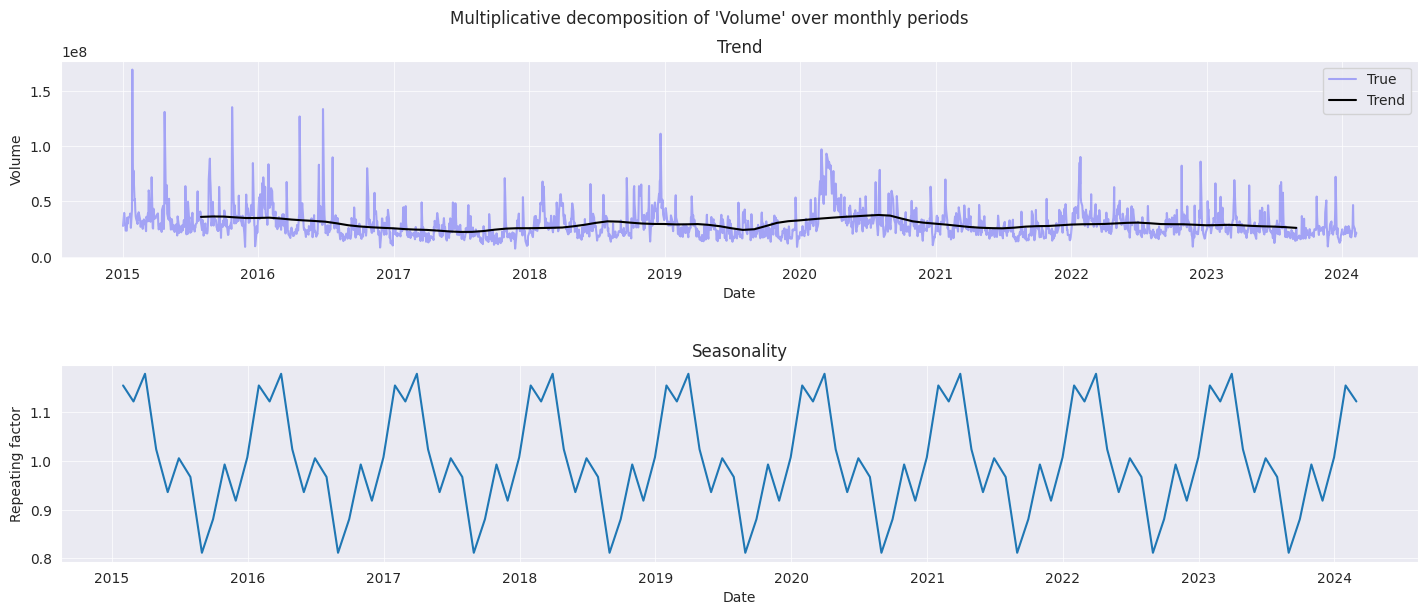

In [20]:
plt.figure(figsize=(15, 6.5))

plt.subplot(2, 1, 1)

# plot trend component
plt.plot(df['Volume'], color='blue', alpha=0.3, label="True")
plt.plot(vol_mult_decom.trend, color='black', label='Trend')
plt.title("Trend")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True, alpha=0.7)

# plot seasonal component
plt.subplot(2, 1, 2)
plt.plot(vol_mult_decom.seasonal)
plt.xlabel("Date")
plt.ylabel("Repeating factor")
plt.title("Seasonality")
plt.grid(True, alpha=0.7)

plt.tight_layout(pad=3)
plt.suptitle("Multiplicative decomposition of 'Volume' over monthly periods")
plt.show()

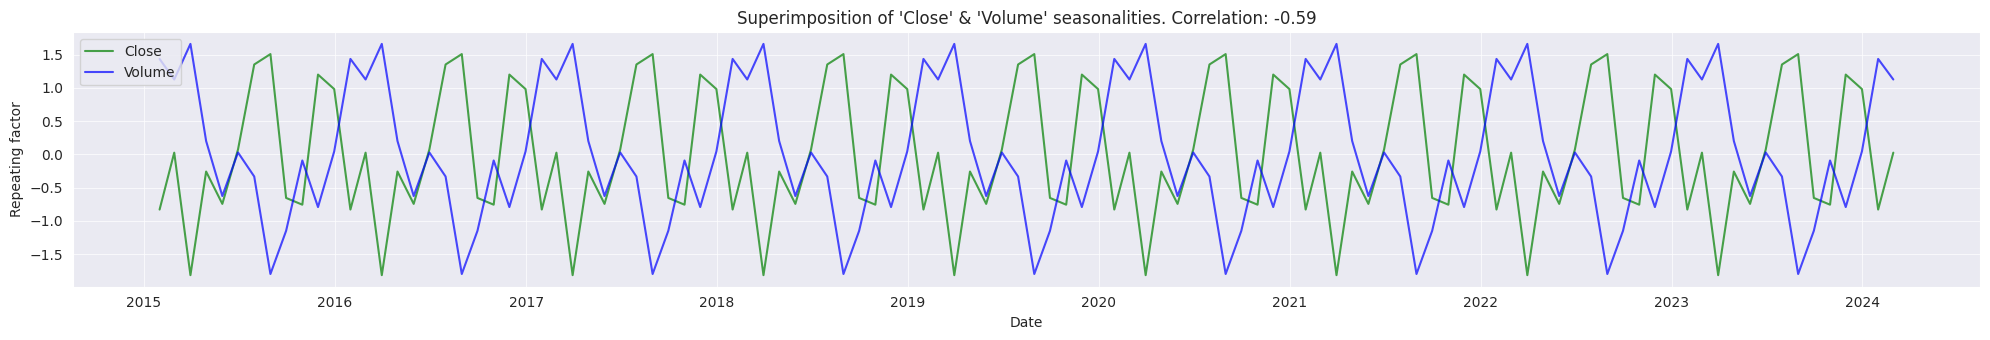

In [21]:
# standardize seasonal components for comparison
std_close_szn = (close_mult_decom.seasonal - np.mean(close_mult_decom.seasonal))/np.std(close_mult_decom.seasonal)
std_vol_szn = (vol_mult_decom.seasonal - np.mean(vol_mult_decom.seasonal))/np.std(vol_mult_decom.seasonal)

plt.figure(figsize=(20, 3.5))

# plot seasonal components
plt.plot(std_close_szn, color="green", label="Close", linestyle='solid', alpha=0.7)
plt.plot(std_vol_szn, color="blue", label="Volume", linestyle='solid', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Repeating factor")
plt.title(f"Superimposition of 'Close' & 'Volume' seasonalities. Correlation: {std_close_szn.corr(std_vol_szn):.02f}")

plt.legend(loc="upper left")
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

There is more than moderate negative correlation between the two seasonalities. The common tendency is to purchase when the stocks have low price and sell when they have high price. Comparing the monthly seasonality, as the stock prices increase, the volume decreases

# Volume profiling

Volume profiling is basically the cumulative sum of all trading volumes for each price (or price range). It is also a function of time. For example, the price that was all the rage during 2000-2005 won't be so in 2015-2020.

It is a trading technique that analyzes the volume traded at each price level over a specified period of time. It is used by traders and analysts to understand the distribution of trading activity and identify prices of significant buying or selling interest.

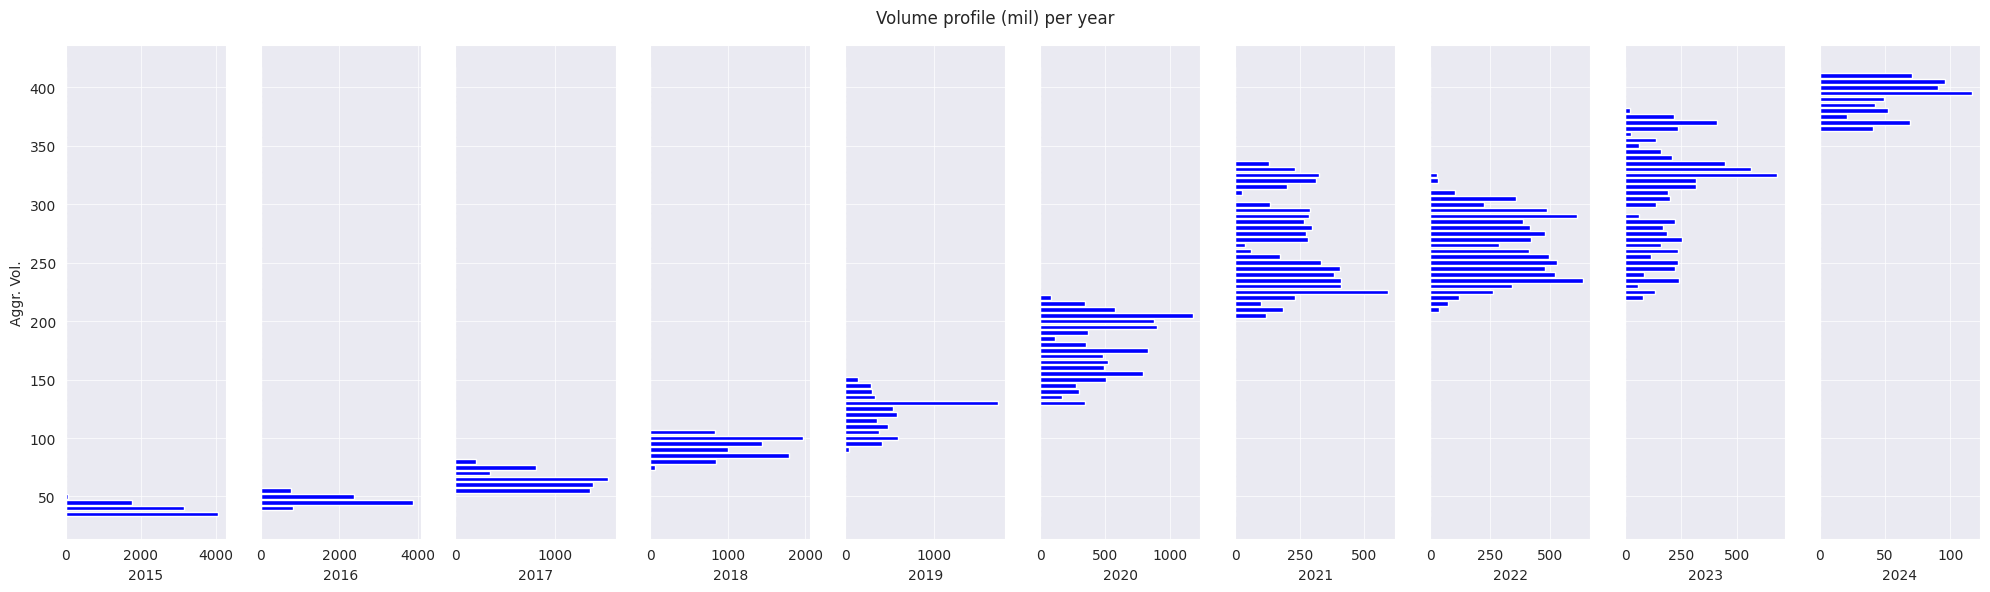

In [22]:
# plt.figure(figsize=(20, 6))

fig, ax = plt.subplots(1, 10, figsize=(20, 6), sharey=True)

bin_size = 5
bins = np.arange(df.Close.min(), df.Close.max(), bin_size)

# Compute aggregated volume for each price bin
for ix, y in enumerate(range(2015, 2025)):
    prices = df.loc[str(y)].Close
    volumes = df.loc[str(y)].Volume/1000000.0

    aggregated_volumes = np.zeros(len(bins) - 1)
    for i in range(len(bins) - 1):
        mask = np.logical_and(prices >= bins[i], prices < bins[i + 1])
        aggregated_volumes[i] = np.sum(volumes[mask])

    ax[ix].barh(bins[:-1], aggregated_volumes, height=bin_size * 0.8, color='blue')
    ax[ix].set_xlabel(y)
    if ix==0:
        ax[ix].set_ylabel("Aggr. Vol.")

    ax[ix].grid(True, alpha=0.7)

plt.suptitle("Volume profile (mil) per year")

fig.tight_layout(rect=[0.3, 0.03, 0, 1])
plt.tight_layout()
plt.show()

To help traders and investors make decisions about the stock market, two major indicators are used:

*   **Volatility** -
Volatility refers to the degree of fluctuation of a stock price series over time. High volatility implies large price oscillations, indicating greater uncertainty or risk, while low volatility suggests relatively stable prices.
*   **Momentum** -
Momentum refers to the direction and strength of a stock's price movement over a period of time. Traders often use momentum indicators to identify trends and potential buying or selling opportunities.

These concepts can be better understood with some calculations and graphs.

# Average True Rate (ATR)

Average True Rate is a measure of volatility calculated by the average of the range of the high and low of a stock over a number of days. The range of each day is taken as the maximum among the following three; 1)  today's high - today's low; 2) absolute of today's high - yesterday's close; and 3) absolute of today's low - yesterday's close.

In [23]:
# get the maximum of the 3 ranges for each day
trdf = pd.DataFrame(columns=['H-L', 'H-C', 'L-C'])
trdf['H-L'] = df['High'] - df['Low']
trdf['H-C'] = abs(df['High'] - df['Close'].shift(1))
trdf['L-C'] = abs(df['Low'] - df['Close'].shift(1))

df['TR'] = trdf.max(axis=1)

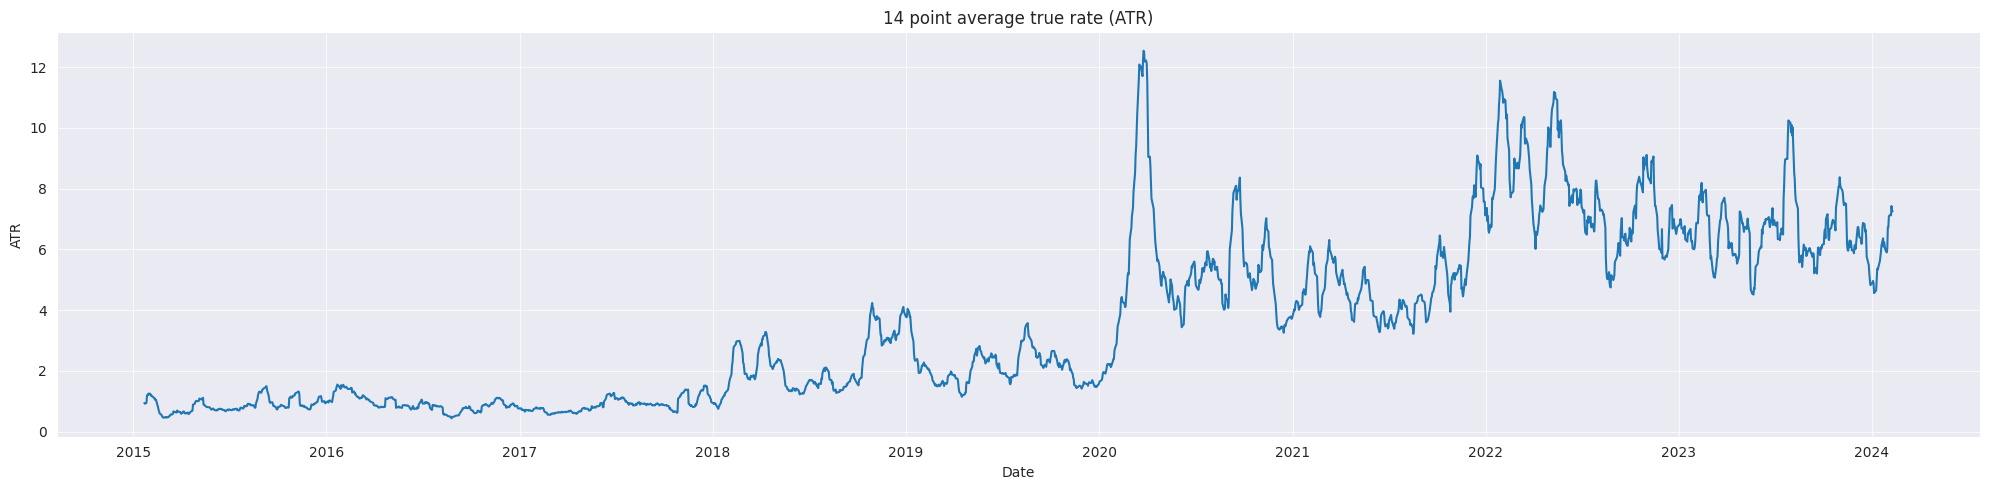

In [24]:
plt.figure(figsize=(20, 5))

# plot the rolling average of the true rate
plt.plot(df["TR"].rolling(14).mean())
plt.title("14 point average true rate (ATR)")
plt.xlabel("Date")
plt.ylabel("ATR")
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

Another index of volatility of stock price is the spread (standard deviation) of daily returns. Daily returns are the percentage change in the closing price of a stock from one day to the next. Standard deviation provides a measure of the average deviation of the daily returns from the mean return. A higher standard deviation indicates higher volatility, while a lower standard deviation suggests lower volatility.

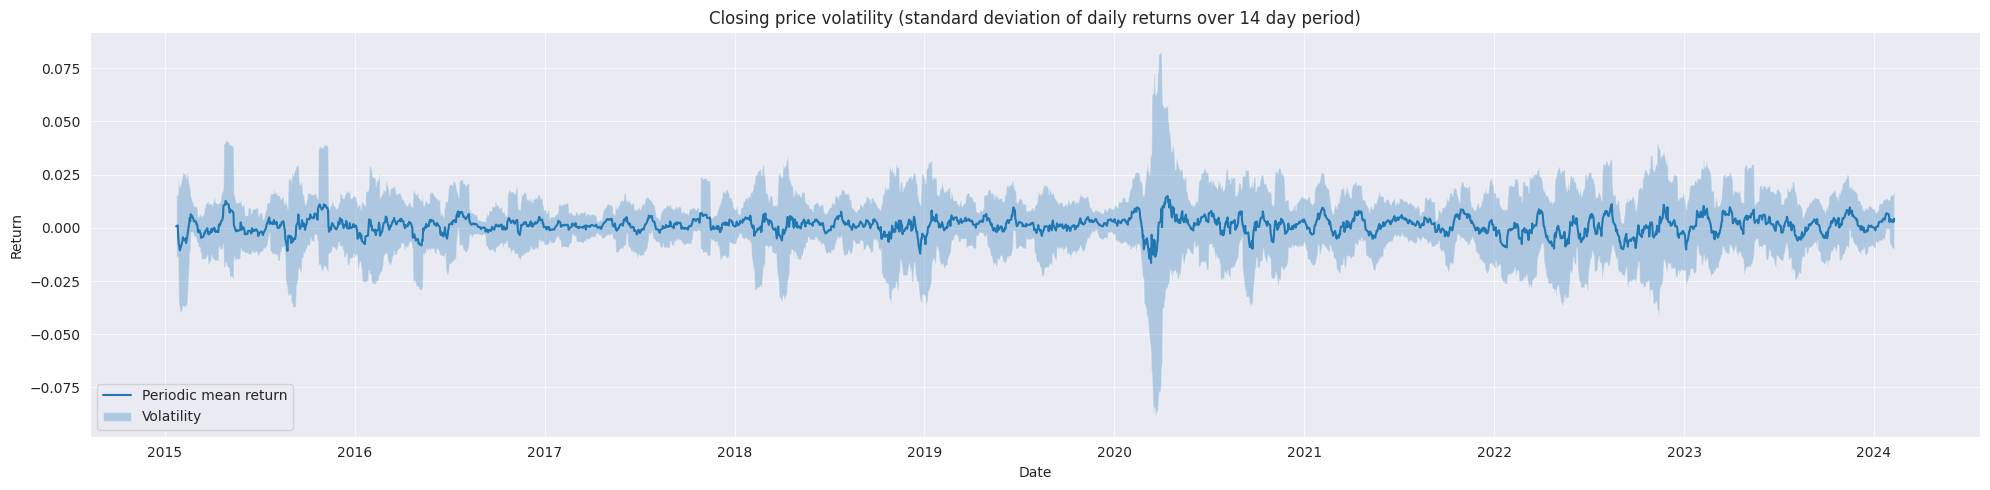

In [25]:
# get daily returns
df['Return'] = df['Close'].pct_change()

# calculate average and standard deviation of daily returns
ret_mean = df['Return'].rolling(14).mean()
ret_std = df['Return'].rolling(14).std()

plt.figure(figsize=(20, 5))


# plot the average daily return with standard deviation
plt.plot(df.index, ret_mean, label='Periodic mean return')
plt.fill_between(df.index, ret_mean-ret_std, ret_mean+ret_std, alpha=0.3, label='Volatility')
plt.title("Closing price volatility (standard deviation of daily returns over 14 day period)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

# Bollinger bands

This is the third way of measuring price volatility of a stock or asset. The **bands** refer to upper and lower lines about a central line. The central line is a simple moving average of the actual series with a certain period. The upper and lower lines (bands) are obtained by the standard deviation during the same period, multiplied by an integer. A thicker band around the central line demonstrates high price volatility while thinner regions represent more stable price periods.

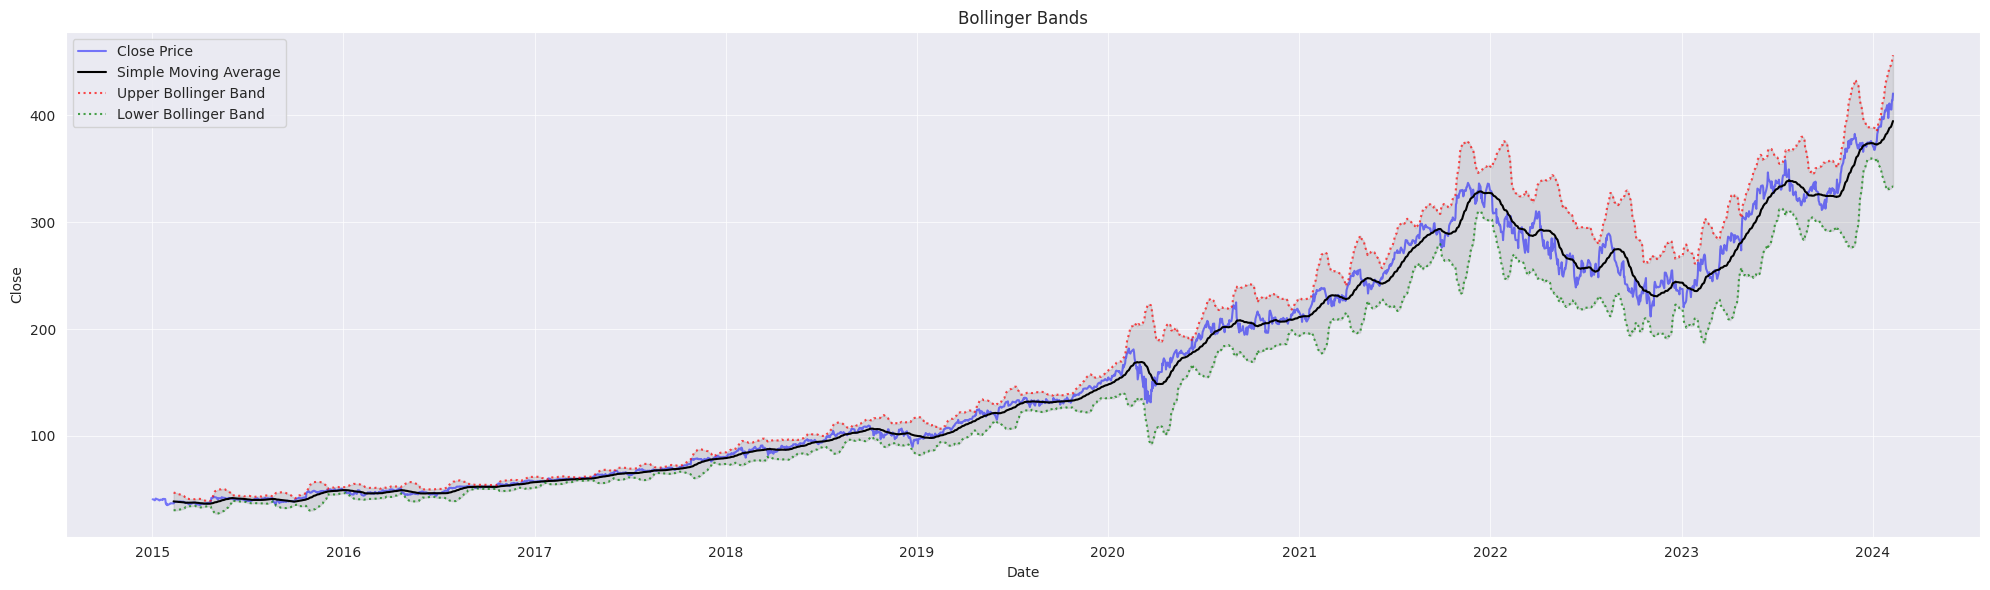

In [26]:
# Calculate Bollinger Bands

sma = df['Close'].rolling(28).mean()  # Calculate simple moving average
std = df['Close'].rolling(28).std()  # Calculate standard deviation
upper_band = sma + (4 * std)  # Upper Bollinger Band
lower_band = sma - (4 * std)  # Lower Bollinger Band

# Plot Bollinger Bands
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(df.index, sma, label='Simple Moving Average', color='black')
plt.plot(df.index, upper_band, label='Upper Bollinger Band', color='red', linestyle='dotted', alpha=0.7)
plt.plot(df.index, lower_band, label='Lower Bollinger Band', color='green', linestyle='dotted', alpha=0.7)
plt.fill_between(df.index, lower_band, upper_band, color='gray', alpha=0.2)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

# Relative strength index

The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. Developed by J. Welles Wilder, the RSI is used to identify overbought or oversold conditions in a market, as well as to confirm the strength of a trend.

How it's calculated is that you get two series, one for all the times there were up closes (gain) from the preceding day, another where there were down closes (loss). When the above condition is not satisfied for either series, fit a 0 to maintain the same length as the original series. Now take a rolling average of both the series. Next, calculate relative strength (RS) of the stock price by dividing the SMA series of gain by that of loss.

Put the series in the formula 100 - (100 / (1 + RS)) to get the relative strength index (RSI) series.

The RSI helps understand overbought and oversold conditions. Since its values always lie between 0 and 100, traders often set two points, (e.g., 30 & 70) as thresholds for these conditions. If the RSI of a stock rises above 70, it signifies overbought condition and indicates that the price will fall soon. Whereas, if it drops below 30, it represents oversold conditions and indicates that the price may rise soon.

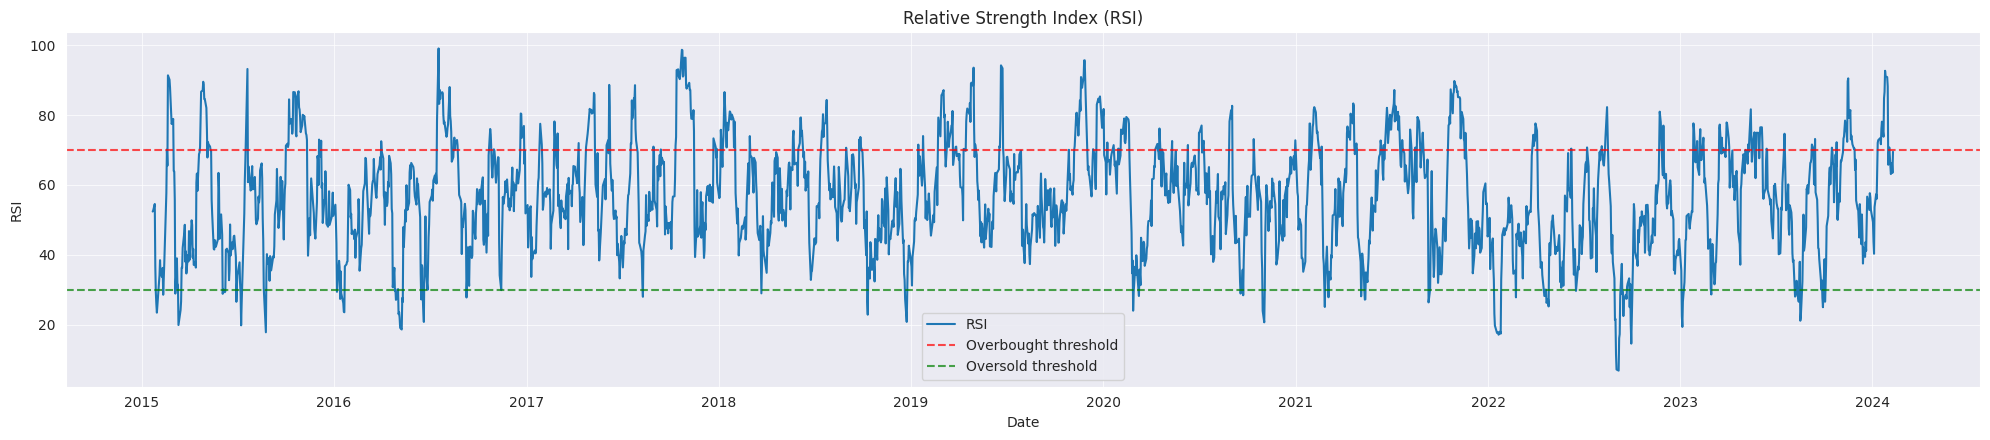

In [27]:
# Calculate price changes and gains/losses
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()

# Calculate relative strength (RS)
rs = gain / loss

# Calculate RSI
rsi = 100 - (100 / (1 + rs))

# Plot RSI
plt.figure(figsize=(20, 4.5))
plt.plot(df.index, rsi, label='RSI')
plt.axhline(70, linestyle='dashed', alpha=0.7, color='red', label="Overbought threshold")  # Overbought threshold
plt.axhline(30, linestyle='dashed', alpha=0.7, color='green', label="Oversold threshold")  # Oversold threshold
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

# MACD

The Moving Average Convergence Divergence (MACD) is a popular momentum indicator used in technical analysis to identify changes in the strength, direction, momentum, and duration of a trend in an asset's price.

It makes use of exponential weighing of values. There are 2 lines namely MACD line and signal line. When the MACD line goes over the signal line, it suggests that the stock price may rise while if it goes below, then the price may fall.

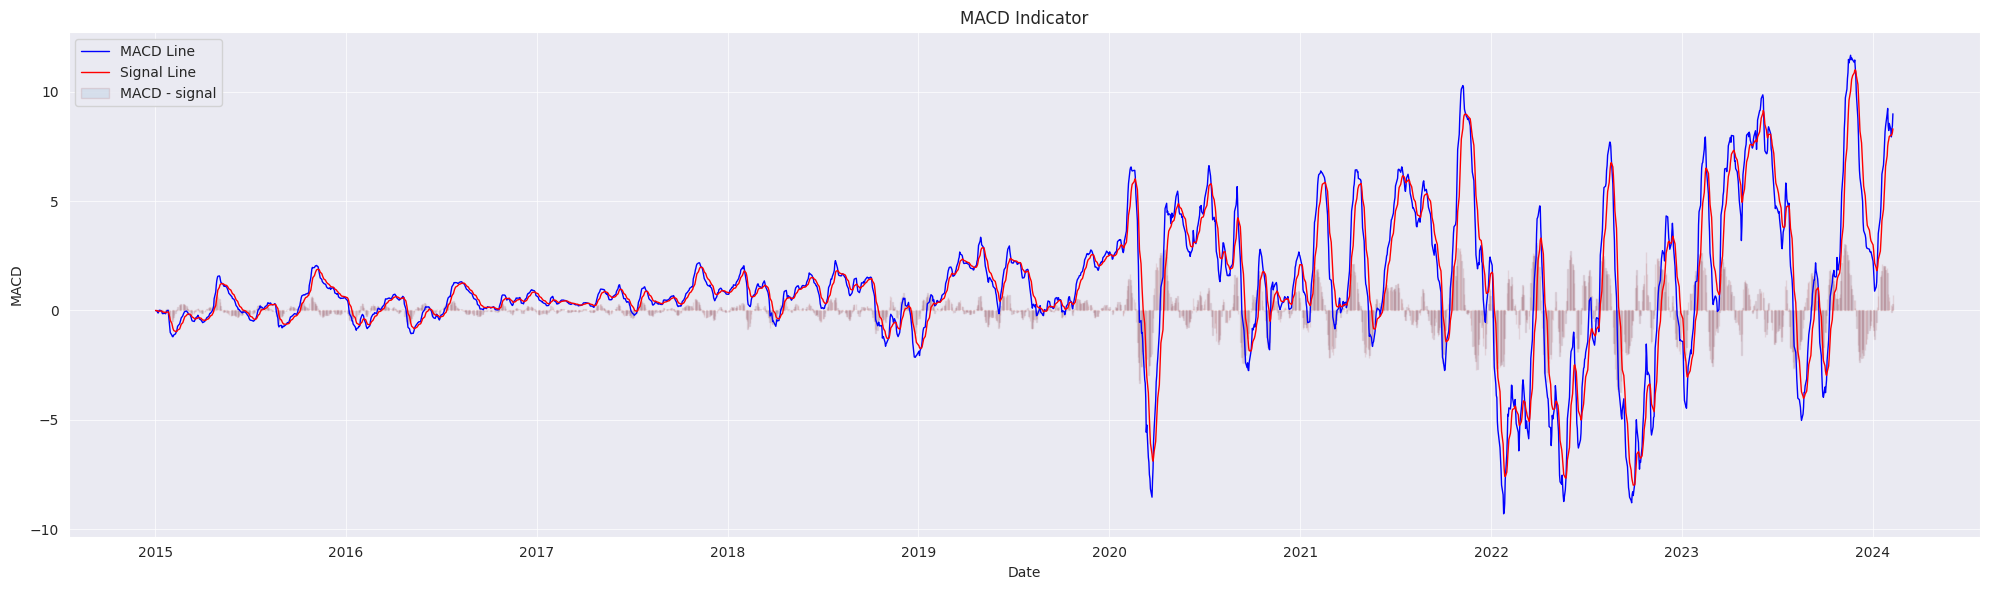

In [49]:
# Calculate MACD line
ema_12 = df['Close'].ewm(span=12, min_periods=0, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, min_periods=0, adjust=False).mean()
macd_line = ema_12 - ema_26

# Calculate signal line
signal_line = macd_line.ewm(span=9, min_periods=0, adjust=False).mean()

# Calculate MACD histogram
macd_histogram = macd_line - signal_line

# Plot MACD
plt.figure(figsize=(20, 6))
plt.plot(df.index, macd_line, label='MACD Line', color='blue', linewidth=1)
plt.plot(df.index, signal_line, label='Signal Line', color='red', linewidth=1)
plt.bar(df.index, macd_histogram, label='MACD - signal', linewidth=1, edgecolor='darkred', alpha=0.1)
plt.title('MACD Indicator')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()